In [185]:
from linearmodels import IV2SLS
import pandas as pd
import os
import numpy as np
import matplotlib.dates as mdates

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

In [213]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df

,aggregated(no_dist_heat),dist_heat,aggregated(incl_small_chp),slp_the [TWh],rlm_the [TWh],bdew [TWh],electricity_from_gas,gas_price [$/lhs],index,time,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2021-01-01,2.146070,0.110337,2.326920,NaN,NaN,3.544281,0.522071,NaN,2021-01-01,0.0,2021,1,Friday,4,0,1,0,0,1,0
2021-01-02,2.120128,0.109003,2.298791,NaN,NaN,3.672925,0.570382,NaN,2021-01-02,1.0,2021,1,Saturday,5,0,0,1,0,0,0
2021-01-03,2.156039,0.110849,2.337728,NaN,NaN,3.730913,0.378169,NaN,2021-01-03,2.0,2021,1,Sunday,6,0,0,1,0,0,0
2021-01-04,2.255681,0.115972,2.445767,NaN,NaN,4.477985,0.686360,19.840,2021-01-04,3.0,2021,1,Monday,0,1,0,0,0,0,0
2021-01-05,2.250272,0.115694,2.439902,NaN,NaN,4.672453,0.749740,18.000,2021-01-05,4.0,2021,1,Tuesday,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,1.340926,0.068942,1.453926,1.392374,1.752227,2.692656,0.501134,96.302,2022-03-21,444.0,2022,3,Monday,0,1,0,0,0,0,0
2022-03-22,1.248650,0.064197,1.353873,1.298474,1.763850,2.834050,0.635613,98.745,2022-03-22,445.0,2022,3,Tuesday,1,0,0,0,0,0,0
2022-03-23,1.164591,0.059876,1.262731,1.192761,1.722181,2.790061,0.656999,117.000,2022-03-23,446.0,2022,3,Wednesday,2,0,0,0,0,0,0
2022-03-24,1.132335,0.058217,1.227757,1.139399,1.723889,2.802156,0.667661,111.610,2022-03-24,447.0,2022,3,Thursday,3,0,0,0,0,0,0


In [218]:
df.index = pd.to_datetime(df.index)

# Disaggregation based on fundamental assumption / energy balances

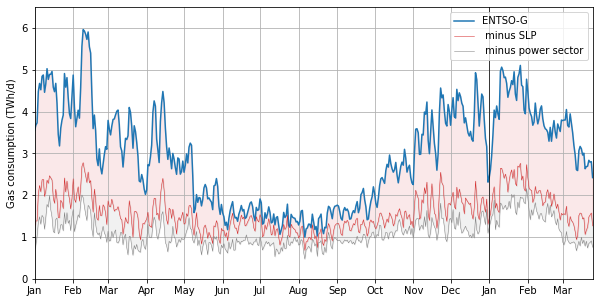

In [217]:
plt.figure(figsize=(10,5))

entso_g = df['bdew [TWh]']
entso_g.plot(label='ENTSO-G')

slp_res = entso_g - df['aggregated(incl_small_chp)']
plt.plot(df.index, slp_res, color='tab:red', label=' minus SLP', linewidth=0.5)
plt.fill_between(df.index, entso_g, slp_res, color='tab:red', alpha=0.1)

power_res = slp_res - df['electricity_from_gas']
plt.plot(df.index, power_res, color='tab:grey', label=' minus power sector', linewidth=0.5)
plt.fill_between(df.index, slp_res, power_res, color='tab:grey', alpha=0.1)

#plt.fill_between(df.index, power_res, 0, color='tab:blue', alpha=0.1)


plt.xlim('2021-01-01', '2022-03-25')
plt.ylim(0, 6.5)
plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))


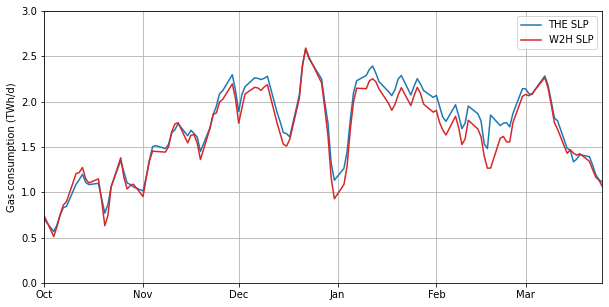

In [219]:
plt.figure(figsize=(10,5))
dft = df.dropna()
plt.plot(dft.index, dft['slp_the [TWh]'], label='THE SLP')
plt.plot(dft.index, dft['aggregated(no_dist_heat)'], color='tab:red', label='W2H SLP')
plt.xlim(dft.index[[0, -1]])

plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))


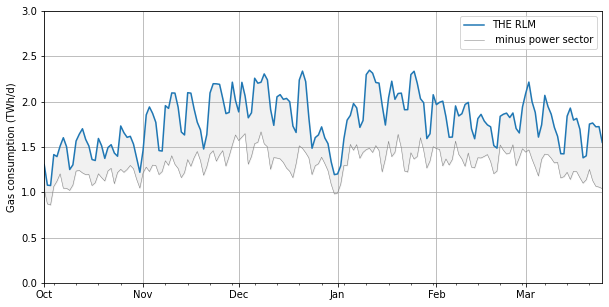

In [224]:
plt.figure(figsize=(10,5))

the_rlm = df['rlm_the [TWh]']
the_rlm.plot(label='THE RLM')

power_res = the_rlm - df['electricity_from_gas']
plt.plot(df.index, power_res, color='tab:grey', label=' minus power sector', linewidth=0.5)
plt.fill_between(df.index, the_rlm, power_res, color='tab:grey', alpha=0.1)

#plt.fill_between(df.index, power_res, 0, color='tab:blue', alpha=0.1)

plt.xlim(dft.index[[0, -1]])
plt.ylim(0, 3)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)
plt.grid()
plt.legend(loc='upper right')
plt.ylabel('Gas consumption (TWh/d)')

X = plt.gca().xaxis
X.set_major_locator(mdates.MonthLocator())
X.set_major_formatter(mdates.DateFormatter('%b'))

In [199]:
df['slp_the [TWh]'].dropna()

2021-10-01    0.701800
2021-10-02    0.610800
2021-10-03    0.506066
2021-10-04    0.565016
2021-10-05    0.638871
                ...   
2022-03-21    1.392374
2022-03-22    1.298474
2022-03-23    1.192761
2022-03-24    1.139399
2022-03-25    1.110757
Name: slp_the [TWh], Length: 176, dtype: float64

# Estimations: X^= a + b*X

In [127]:
df_x = df

df_x = df_x.rename(columns = {
    "aggregated(no_dist_heat)" : "slp_w2h",
    "dist_heat": "slp_w2h_dh",
    "slp_the [TWh]" : "slp_the",
    "rlm_the [TWh]" : "rlm_the",
    "bdew [TWh]" : "bdew",
    "pure power": "power_0",
    "excl_ind_pp" : "power_1",
    "incl_ind_pp" : "power_2",
    "gas_price [$/lhs]" : "prices"
})

df_x["the_sum"] = df_x["rlm_the"] + df_x["slp_the"]

df_x["bdew_res_0"] = df_x["bdew"] - df_x["power_0"]
df_x["bdew_res_1"] = df_x["bdew"] - df_x["power_1"]
df_x["bdew_res_2"] = df_x["bdew"] - df_x["power_2"]

df_x["rlm_the_res_1"] = df_x["rlm_the"] - df_x["power_1"]

In [129]:
(df_x['slp_w2h_dh']/df_x['slp_w2h']).mean()

0.05141337593275145

In [130]:
df_x_no_holiday = df_x[(df_x.holiday==0) & (df_x.christmas_period==0) & (df_x.bridgeday==0)]

In [131]:
df_x_no_holiday.columns

Index(['slp_w2h', 'slp_w2h_dh', 'slp_the', 'rlm_the', 'bdew', 'power_0',
       'power_1', 'power_2', 'prices', 'index', 'time', 'year', 'month',
       'weekday', 'weekday_num', 'monday', 'friday', 'weekend',
       'christmas_period', 'holiday', 'bridgeday', 'the_sum', 'bdew_res_0',
       'bdew_res_1', 'bdew_res_2', 'rlm_the_res_1'],
      dtype='object')

## bdew

In [132]:
df_x.index = pd.to_datetime(df_x.index)

In [133]:
df_x.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-03-16', '2022-03-17', '2022-03-18', '2022-03-19',
               '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
               '2022-03-24', '2022-03-25'],
              dtype='datetime64[ns]', length=449, freq=None)

In [134]:
import matplotlib.pyplot as plt

In [135]:
model = IV2SLS.from_formula('bdew_res_1 ~ 1 + slp_w2h + C(weekend)', data=df_x_no_holiday)
results = model.fit() 
results

OLS Estimation Summary                            
==============================================================================
Dep. Variable:             bdew_res_1   R-squared:                      0.9451
Estimator:                        OLS   Adj. R-squared:                 0.9448
No. Observations:                 412   F-statistic:                    7836.5
Date:                Tue, Apr 12 2022   P-value (F-stat)                0.0000
Time:                        15:50:52   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           0.8353     0.0177     47.321     0.0000      0.8007      0.8699
C(weekend)[T.1]    -0.1342     0.0266    -5.0385     0.0000     -0.1864     -0.0820
slp_w2h             1.3981     0.0158     88.499     0.0000      1.3671      1.4291
===================================================================================
OLSResults, id: 0x29131663b50

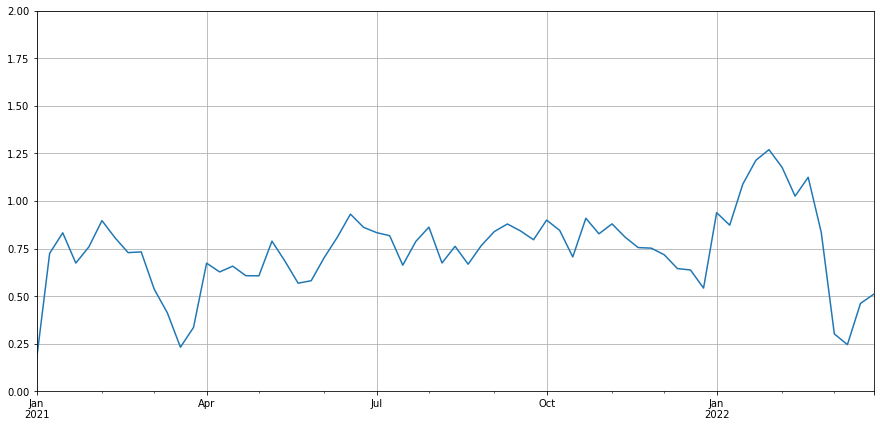

In [143]:
(df_x['bdew'] - df_x['power_1'] - 1.44 * df_x['slp_w2h']).resample('1w').mean().plot(figsize=(15,7), ylim=(0,2))
plt.grid()

In [151]:
model = IV2SLS.from_formula('rlm_the ~ 1 + slp_w2h + power_1 + C(weekend)', data=df_x_no_holiday)
results = model.fit() 
results

C:\Users\olive\miniconda3\lib\site-packages\linearmodels\shared\exceptions.py:35: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


OLS Estimation Summary                            
==============================================================================
Dep. Variable:                rlm_the   R-squared:                      0.9369
Estimator:                        OLS   Adj. R-squared:                 0.9356
No. Observations:                 156   F-statistic:                    2843.8
Date:                Tue, Apr 12 2022   P-value (F-stat)                0.0000
Time:                        16:00:36   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           1.0029     0.0211     47.427     0.0000      0.9614      1.0443
C(weekend)[T.1]    -0.1847     0.0150    -12.318     0.0000     -0.2141     -0.1553
slp_w2h             0.3244     0.0222     14.615     0.0000      0.2809      0.3679
power_1             0.8235     0.0600     13.722     0.0000      0.7059      0.9411
===================================================================================
OLSResults, id: 0x29131d71e80

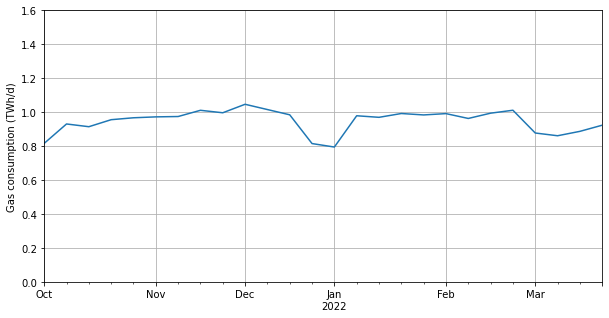

In [230]:
(df_x['rlm_the'] - 0.82 * df_x['power_1'] - 0.32 * df_x['slp_w2h']).resample('1w').mean().dropna().plot(figsize=(10,5), ylim=(0,2))
plt.ylim(0,1.6)
plt.ylabel('Gas consumption (TWh/d)')
plt.grid()

In [39]:
model = IV2SLS.from_formula('bdew_res_2 ~ 1 + slp_w2h + power_1', data=df_x_no_holiday)
results = model.fit() 
results

OLS Estimation Summary                            
==============================================================================
Dep. Variable:             bdew_res_2   R-squared:                      0.9377
Estimator:                        OLS   Adj. R-squared:                 0.9376
No. Observations:                 412   F-statistic:                    7192.2
Date:                Tue, Apr 12 2022   P-value (F-stat)                0.0000
Time:                        15:08:35   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.7251     0.0162     44.700     0.0000      0.6933      0.7569
slp_w2h        1.3579     0.0160     84.807     0.0000      1.3265      1.3893
==============================================================================
OLSResults, id: 0x29129ff6b20

In [ ]:
d_R2 = {"bdew":
     {"weekend":0.8156,
      "weekday":0.8156,
       "weekday":0.8156
     }
    
}

In [ ]:
Next steps:
RLM* = RLM_THE_res (- X * SLP)

bdew auf 2021 fitten mit a(SLP) 

plot estimate_bdew_2021 vs bdew_2021

Powersektor
1) nur residual und plot estimate_res + power vs bdew_res + power 
2) als Kontrollvariable: Ewartung: 25% 

model.fit ohne weihnacht, dann plot, dann model.predict für 2022

In [ ]:
formula = 'bdew ~ 1 + slp_w2h + C(weekend)'

formula = ('load') + ' ~ 1 + ' + ' + '.join(
    controls + ['C({})'.format(d) for d in time_dummies]
)

In [ ]:
pd.concat(
    [results.params, results.std_errors], axis=1
)#.to_csv('results.csv')

In [89]:
def extract(x):
    #x1 = x.first_stage.diagnostics
    return {
        'estimate': x.params['price'],
        'errors': x.std_errors['price']#,
        #'prsq': x1['partial.rsquared']['price'],
        #'fstat': x1['f.stat']['price']
    }